# wk7 Demo - Regularization & Gradient Descent con't
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2022`__

Last week we talked about optimization theory in the context of the supervised learning of a parametric model. Gradient descent allows us to find the model parameters that minimize a loss function, provided that the loss function is (pseudo) convex. Full batch GD is easy to parallelize, however the need to make many passes over the entire dataset is still a cost we'd like to minimize when processing large scale data. Today we'll dive a bit further into techniques for improving the training of supervised ML models. By the end of this live session you should be able to:
* __... explain__ why and how we regularize linear and logistic regression models.
* __... compare__ L1 and L2 regularization in terms of their effects on model parameters.
* __... identify__ a few common gradient descent variants.
* __... describe__ the numerical approximization method & when we might use it.


### Notebook Set-Up

In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Some helper functions

In [7]:
#!/opt/anaconda/bin/python
"""
Helper functions for w261 week7 demo: regularized linear regression
"""
# general imports
import sys
import csv
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


def OLSLoss(X, y, model):
    """
    Computes mean squared error for a linear model.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    N = len(X)
    W = np.array(model)
    return 1/float(N) * sum((W.dot(X.T) - y)**2)

def OLSGradient(X, y, model):
    """
    Computes the gradient of the OLS loss function for
    the provided data & linear model.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    N = len(X)
    W = np.array(model)
    return 2.0/N *(W.dot(X.T) - y).dot(X)

def RidgeGradient(X, y, model, reg_param):
    """
    Ridge regression gradient.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    w = np.array(model[:-1])
    reg_term = reg_param * 2 * w
    return OLSGradient(X,y,model) + reg_term

def LassoGradient(X, y, model, reg_param):
    """
    Lasso regression gradient.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            model  - [w_0, w_1] (coefficient & bias)
    """
    w = model[:-1]
    reg_term = reg_param * np.sign(w)
    return OLSGradient(X,y,model) + reg_term

def GDUpdate(X, y, nIter, init_model, learning_rate,
             reg_type = None, reg_param = 0, verbose = True):
    """
    Performs Gradient Descent Updates for linear models using OLS Loss
    or a specified regularization (l1/l2) method.
    INPUT:  X - numpy array (each row = augmented input point)
            y - numpy array of true outputs
            nIter - number of updates to perform
            init_model  - array w/ bias in last term
            learning_rate - step size for the update
            reg_param - regularization parameter
            verbose - (optional) printout each update
    OUTPUT: dict of {'models':[], 'loss':[]}
    """
    # keep track of our progress
    models = [init_model]
    loss = [OLSLoss(X,y,init_model)]

    # initialize gradient function
    if reg_type == 'l2':
        grad = lambda X,y,theta: RidgeGradient(X,y,theta,reg_param)
    elif reg_type == 'l1':
        grad = lambda X,y,theta: LassoGradient(X,y,theta,reg_param)
    else:
        grad = lambda X,y,theta: OLSGradient(X,y,theta)
    # perform updates
    for idx in range(nIter):
        gradient = grad(X, y, models[-1])
        update = np.multiply(gradient,learning_rate)
        new_model = models[-1] - update
        models.append(new_model)
        loss.append(OLSLoss(X,y,new_model))

    # return training history
    return np.array(models), loss

def plotLossContours(ax, X, y, w0_min, w0_max, w1_min, w1_max,
                    loss_func = OLSLoss):
    """
    OLS loss contours in the specified range added to the specified axis.
    This function passes a grid of 2D models to OLSLoss.
    """
    # grid parameters
    w0_step = (w0_max - w0_min)/20
    w1_step = (w1_max - w1_min)/20
    # create loss grid (flat for now)
    grid_w0, grid_w1 = np.mgrid[w0_min:w0_max:w0_step,
                                w1_min:w1_max:w1_step]
    grid_loss = [OLSLoss(X, y, model)
                 for model in zip(grid_w0.flatten(), grid_w1.flatten())]
    # plot loss contours
    topo_levels = np.logspace(min(np.log(min(grid_loss)),0.1),
                              min(np.log(max(grid_loss)),20))
    CS = ax.contour(grid_w0, grid_w1, np.array(grid_loss).reshape(20,20),
                    levels = topo_levels, cmap = 'rainbow',
                    linewidths = 2.0, alpha=0.35)


def compareDescent(X, y, hist1, hist2, labels):
    """
    Compare the two training histories
    Args:
        hist1, hist2 - lists of 2D models
        labels - names for the plot legend
        X, y - data
    """
    # set up axes
    fig, ax = plt.subplots(figsize=(10,6))
    ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_title("Model Parameter Space", fontsize=18)
    ax.set_xlabel('w_0')
    ax.set_ylabel(f'w_1')

    # plot the two training paths
    ax.plot(hist1.T[0], hist1.T[1], 'k', label=labels[0])
    ax.plot(hist2.T[0], hist2.T[1], 'k--', label=labels[1])

    # add contour plots
    w0_min = min(hist1.T[0].min(), hist2.T[0].min()) - 0.1
    w1_min = min(hist1.T[1].min(), hist2.T[1].min()) - 0.1
    w0_max = max(hist1.T[0].max(), hist2.T[0].max()) + 0.1
    w1_max = max(hist1.T[1].max(), hist2.T[1].max()) + 0.1
    plotLossContours(ax, X, y, w0_min, w0_max, w1_min, w1_max)

    # include legend
    plt.legend()
    

def plot2D(ax, X, y, xdim, color = 'b'):
    """
    Plot a higher dimensional dataset in 2D by
    electing just one of X's dimension to show.
    """
    # set up axes
    ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_title(f"2D projection (dimension {xdim})", fontsize=12)
    ax.set_xlabel(f'x_{xdim}')
    ax.set_ylabel('y')
    # plot the data
    ax.plot(X[:,xdim], y, 'o')


def compare2Dprojections(X, y, xdim, models, labels):
    """
    View side by side plots of n-dimensional models + data
    projected into 2D via the xdim.
    Args:
        models - list of sklearn linear models
        labels - same dimension titles
    """
    nmodels = len(models)

    # identify segments for projecting models down to 2D
    vals = X.T[xdim]
    ranges = [(vals[i], vals[i+1]) for i in range(len(vals) - 1)]

    # set up the plots
    fig, axes = plt.subplots(1,nmodels, figsize = (10,4))

    # plot each model
    for ax, lm, name in zip(axes, models, labels):

        # add data & title
        plot2D(ax, X, y, xdim)
        ax.set_title(name, fontsize=18)

        # apply model
        y_pred = lm.predict(X)
        x_vals = list(X.T[xdim])
        points = sorted(zip(x_vals, y_pred), key=lambda pair: pair[0])

        # add projections by segment
        for (x1,y1), (x2,y2) in zip(points[:-1], points[1:]):
            ax.plot([x1,x2],[y1,y2],'r--', alpha=0.5)


def compareLossCurves(X, y, reg_type, reg_param, grid):
    """
    Plot ridge & lasso curves (2D versions) alongside OLS.
    """
    # weights
    w0,w1 = grid

    # compute loss with & without regularization
    loss_no_reg = []
    loss_w_reg = []
    for W in grid.T:
        loss = OLSLoss(X,y,W)
        loss_no_reg.append(loss)
        if reg_type == 'l1':
            loss += np.abs(W[0]) * reg_param
        if reg_type == 'l2':
            loss += W[0]**2 * reg_param
        loss_w_reg.append(loss)

    # create figure
    fig = plt.figure(figsize = (15,12))

    # Lasso
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax1.set_title(f"L1 penalty term (lambda = {reg_param})", fontsize=12)
    ax1.set_xlabel('w_0 (coefficient)')
    ax1.set_ylabel(f'w_1 (bias)')
    surf1 = ax1.plot_trisurf(w0, w1, np.abs(w0) * reg_param, cmap=cm.rainbow,
                            linewidths = 2.0, alpha=0.65)

    # Ridge
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    #ax2.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax2.set_title(f"L2 penalty term (lambda = {reg_param})", fontsize=12)
    ax2.set_xlabel('w_0 (coefficient)')
    ax2.set_ylabel(f'w_1 (bias)')
    surf2 = ax2.plot_trisurf(w0, w1, w0**2 * reg_param, cmap=cm.rainbow,
                            linewidths = 2.0, alpha=0.65)

    # OLS
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    #ax3.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax3.set_title(f"OLS with no penalty", fontsize=12)
    ax3.set_xlabel('w_0 (coefficient)')
    ax3.set_ylabel(f'w_1 (bias)')
    surf3 = ax3.plot_trisurf(w0, w1, loss_no_reg, cmap=cm.rainbow,
                            linewidths = 2.0, alpha=0.65)

    # OLS w/ reg
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    #ax4.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax4.set_title(f"OLS with {reg_type} penalty (lambda = {reg_param})", fontsize=12)
    ax4.set_xlabel('w_0 (coefficient)')
    ax4.set_ylabel(f'w_1 (bias)')
    surf4 = ax4.plot_trisurf(w0, w1, loss_w_reg, cmap=cm.rainbow,
                            linewidths = 2.0, alpha=0.65)



# Vanilla Linear Regression Review 

** Linear Regression model prediction (vectorized form)** 

$
\hat{y} =  \mathbf{X}  \mathbf{\theta}
$

Here $X$ corresponds to $m  \times n$ input data matrix; $y$ corresponds to the true target values in  $m  \times 1$ vector form; and  $\hat{y}$ corresponds to the true target values in  $m  \times 1$ vector form

** MSE cost function for a Linear Regression model**

This can also be broken down to an equivalent summation over individual examples (this is less desirable computationally as it involves a summation-based $for$ loop:
 
$
\text{MSE}(\mathbf{X}, h_{\mathbf{\theta}}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{(\mathbf{\theta}^T \cdot \mathbf{x}^{(i)} - y^{(i)})^2}
$


** Normal Equation**

$
\hat{\mathbf{\theta}} = (\mathbf{X}^T \cdot \mathbf{X})^{-1} \cdot \mathbf{X}^T \cdot \mathbf{y}
$


** Partial derivatives notation :**

$\frac{\partial}{\partial \theta_j} \text{MSE}(\mathbf{\theta})$


** Partial derivatives of the cost function**

$
\dfrac{\partial}{\partial \theta_j} \text{MSE}(\mathbf{\theta}) = \dfrac{2}{m}\sum\limits_{i=1}^{m}(\mathbf{\theta}^T \cdot \mathbf{x}^{(i)} - y^{(i)})\, x_j^{(i)}
$


**Gradient vector of the cost function**

$
\nabla_{\mathbf{\theta}}\, \text{MSE}(\mathbf{\theta}) =
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\mathbf{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\mathbf{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\mathbf{\theta})
\end{pmatrix}
 = \dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})
$



** Gradient Descent step in vectorized form**

$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{MSE}(\mathbf{\theta})
$


### Worked out example (but try by yourself for practice)

The following is a review of the gradient update for NON regularized linear regression. Given the current weight vector (2, 5, 4, 8) for a linear regression model, and a single training example (34, 1, 4) [HINT: training data is not augmented], and a learning rate of 0.01, calculate the new weight vector after doing a single gradient update step. Report your response to 2 decimal places. The corresponding output value for this training example is 206.

####  Summary of problem: 
* Model = [2, 5, 4, 8]
* training example [[34, 1, 4],  206]
* Learning rate is 0.01
* Do a stochastic gradient descent update of the model and report the updated model


### Let's do it in code

$
\text{MSE}(\mathbf{X}, h_{\mathbf{\theta}}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{(\mathbf{\theta}^T \cdot \mathbf{x}^{(i)} - y^{(i)})^2}
$


$
\nabla_{\mathbf{\theta}}\, \text{MSE}(\mathbf{\theta}) =
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\mathbf{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\mathbf{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\mathbf{\theta})
\end{pmatrix}
 = \dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})
$



** Gradient Descent step in vectorized form**

$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{MSE}(\mathbf{\theta})
$

In [18]:
X=np.array([[1, 34, 1, 4]]) # augmented mxn input data matrix
w=np.array([2, 5, 4, 8])    # augmented model
eta = .01                   # learning rate
y = [206]                   # true target value(s)
m = X.shape[0]
#                X^T                  (  y_hat    - y)
w = ........   #gradient update step
w
# array([1.98, 4.32, 3.98, 7.92])  using a gradient  X^T (  y_hat    - y)
# array([1.96, 3.64, 3.96, 7.84]) using a gradient 2/m X^T (  y_hat    - y)

array([1.96, 3.64, 3.96, 7.84])

###  Two or more training examples 

In [ ]:
# 2 training examples 
X_train = [[1, 34, 1, 4], [1, 4,4,4]]  # augmented model
y_train =     [206, 4]
w=np.array([2, 5, 4, 8])    # augmented model
m = X.shape[0]

w=w-....   #gradient update step
w

# Regularized Linear Regression models and examples


$$
\begin{align}\tag{Euclidean norm squared}
\|{\boldsymbol {\theta}}\|_{2}^2&={    {\theta_{1}^{2}+\cdots +\theta_{n}^{2}}}
\end{align}
$$


### Euclidean norm, or 2-norm, L2 Norm
The length of a vector is most commonly measured by the "square root of the sum of the squares of the elements," also known as the Euclidean norm. It is called the 2-norm because it is a member of a class of norms known as 
p-norms.  On the $n$-dimensional Euclidean space $ \mathbb {R} ^{n}$, the intuitive notion of length of the vector ${\boldsymbol {w}}=\left(w_{1},w_{2},\ldots ,w_{n}\right)$ is captured by the formula:

$$
\begin{align}\tag{Euclidean norm, or 2-norm}
\|{\boldsymbol {w}}\|_{2}&={\sqrt {w_{1}^{2}+\cdots +w_{n}^{2}}}\\
\end{align}
$$

In machine learning L2 norm is often used in its squared form.
$$
\begin{align}\tag{Euclidean norm squared}
\|{\boldsymbol {w}}\|_{2}^2&={    {w_{1}^{2}+\cdots +w_{n}^{2}}}
\end{align}
$$

Using L2 norm squared, the term is easily differentiable. Consider a vector $(3,4)$ the length of the vector as calculate via the Euclidean norm or L2 norm is as follows:


$$
\begin{align}\tag{Euclidean norm, or 2-norm}
\|{\boldsymbol {(3,4)}}\|_{2}&={\sqrt {3^{2}+4^{2}}}\\
&=\sqrt(25)\\
&=5
\end{align}
$$
$$
\begin{align}\tag{Euclidean norm squared}
\|{\boldsymbol {(3,4)}}\|_{2}^2&={ {3^{2}+4^{2}}}\\
&=25
\end{align}
$$

Plot the vector $(3,4)$. As you can see in the graphic, L2 norm is the most direct route from the origin to the point.

### Euclidean distance
For two points given by Cartesian coordinates in n-dimensional Euclidean space, $p,$ and $q$, the Euclidean distance is defined as follows:

$$
\begin{align}\tag{Euclidean Distance}
\|\mathbf{p}-\mathbf{q}\|_2 &= {\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{i}-q_{i})^{2}+\cdots +(p_{n}-q_{n})^{2}}}\\
\|\mathbf{p}-\mathbf{q}\|_2^2 &= { {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{i}-q_{i})^{2}+\cdots +(p_{n}-q_{n})^{2}}}
\end{align}
$$

## Vanila MSE regression

Building on that we see that the MSE for linear a regression model can be written in **vectorixed form** as the Euclidean distance between the predicted and true target values, squared:


\begin{align}\tag{2.5b}
MSE(X, y;\boldsymbol{\theta}) &= \frac{1}{m}\|\text{X}\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2   \text{  (i.e.,  the euclidean distance}^2) \\
 &= \frac{1}{m}\left[(\text{X}\cdot \boldsymbol{\theta} - \mathbf{y})\cdot (\text{X}\cdot \boldsymbol{\theta} - \mathbf{y})\right]
\end{align}

The MSE Loss can be summarizesd in terms of $\mathbf{\hat{y}}$ and $\mathbf{{y}}$, the predicted value and true value respectively as follows:

\begin{equation}\tag{2.5c}
f(\boldsymbol{\theta}) = \frac{1}{m}\left[(\mathbf{\hat{y}} - \mathbf{y})\cdot (\mathbf{\hat{y}} - \mathbf{y})\right]
\end{equation}


## Ridge Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting. There are many ways of doing regularization but these two are the major ones:

* **Linear regression L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{m}\sum_{i=1}^{m}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \left[ \sum_{j=1}^{n}w_j^2 \right]
$$
or in matrix/vectorized form:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_m - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w'}\|_2^2
$$
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_m - \mathbf{y}\|_2^2 + \lambda \mathbf{w'}\cdot\mathbf{w'}
$$

where
$$
w' \text{denotes w with } w[0] = 0, \text{i.e., y-intercept is set to zero}
$$



**Gradient vector of the ridge regression cost function vectorized**

$$
\begin{aligned}
\nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta}) &=
 \left[\dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + 2*\lambda \mathbf{\theta'}\\
 &= \left[\dfrac{1}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + \lambda \mathbf{\theta'}
\end{aligned}
$$

where
$$
\theta' \text{denotes } \theta \text{ with } \theta[0] = 0, \text{i.e., y-intercept is set to zero}
$$

**Gradient Descent step**

$$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta})
$$

## Why does regularizing the bias term lead to underfitting for LR?
While fitting a straight line to a dataset (a process known as linear regression), if the bias term is set to 0, i.e., w0=0, the line of best fit will end up always passing through the origin. This is a bad solution as it will lead to large residuals (underfitting) since the straight line is unable to adjust itself in terms of the distance from the origin. Thus, it is advisable to learn the bias term just like we learn the weights. If the dataset demands the line to pass through the origin, the model will automatically learn to set w0 to 0. 

The following example shows with a simple linear regression model that when the bias term is included in regularization it leads to a linear model where the bias term is shrunk to ZERO, thereby generating a bias solution that does not fit the training data well. 

For more details see:
* https://www.deepwizai.com/simply-deep/why-does-regularizing-the-bias-lead-to-underfitting-in-neural-networks

Bias outside regularization : 1149.39990
Bias inside regularization : 0.00000
Bias outside regularization : 958.51889
Bias inside regularization : 0.26414


/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: 

Bias outside regularization : 1063.15777
Bias inside regularization : 0.51430
Bias outside regularization : 977.01192
Bias inside regularization : 0.75810
Bias outside regularization : 950.07852
Bias inside regularization : 1.00143


/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


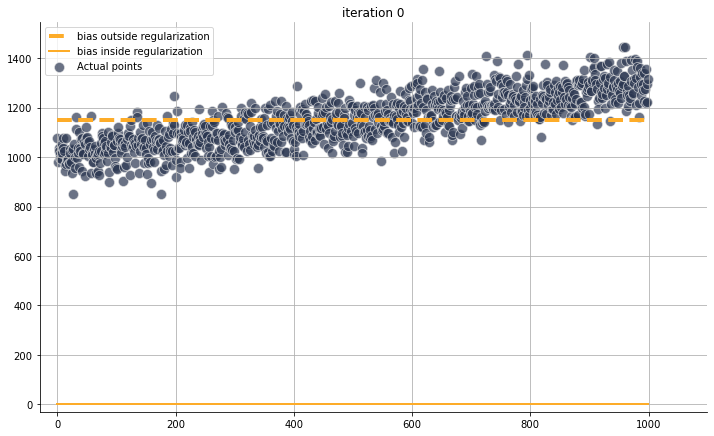

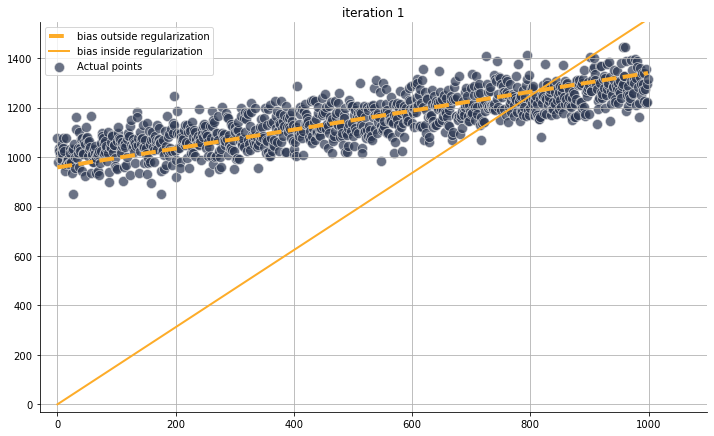

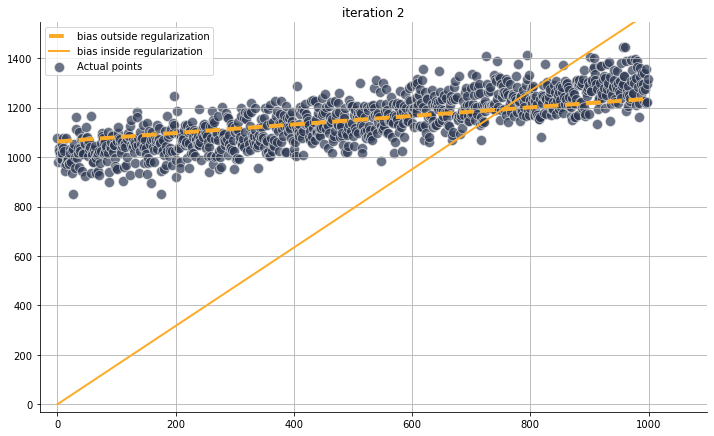

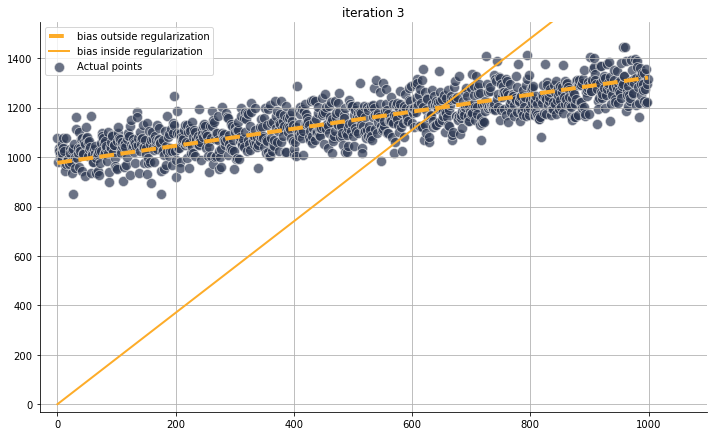

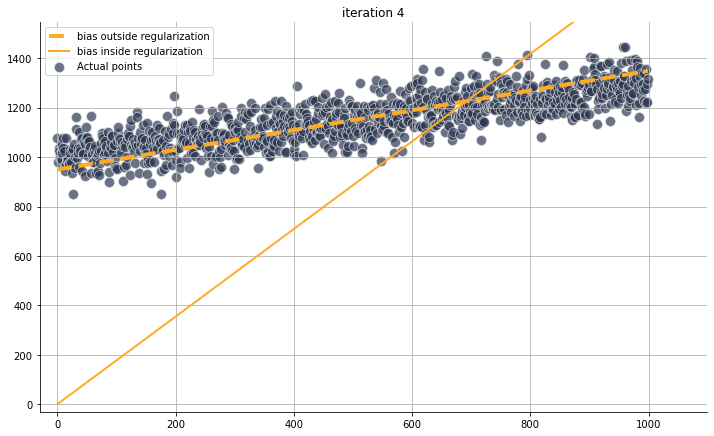

In [1]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(27)
import matplotlib.pyplot as plt


# Define the amount of true bias for the target variable
bias = 1000

# Generate the input (x values)
X = np.arange(1000).reshape(-1,1)
# Generate the true target variable
y_true = np.ravel(np.multiply(X, 0.3) + bias)
# Generate some random noise
noise = np.random.normal(0, 60, 1000)
# Add that noise to the target variable
y = y_true + noise

# Add a column with all values set to 1. This is the pseudo bias
new_X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

alpha = 1 #regularization mixing weight
for i in range(5):
    # L2 regularized model. Bias is not regularized
    # Minimizes the ridge regression objective function::
    # MSE + alpha L2^2
    #.  ||y - Xw||^2_2 + alpha * ||w||^2_2
    # use Stochastic Average Gradient descent
    model = Ridge(alpha=alpha, max_iter=i, fit_intercept=True, solver="sag")
    model.fit(X, y)
    preds1 = model.predict(X)

    # Check out the bias value
    print('Bias outside regularization : {:.5f}'.format(model.intercept_))

    # L2 regularized model. Bias is now regularized
    model = Ridge(alpha=alpha, max_iter=i, fit_intercept=False, solver="sag")
    model.fit(new_X, y)
    preds2 = model.predict(new_X)

    # Check out the regularized bias value
    print('Bias inside regularization : {:.5f}'.format(model.coef_[1]))

    # Display some nice graphics
    figsize=(10,6)
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.scatter(X, y, label='Actual points', marker='o', s=100, color="#2B3751", edgecolors="#E5E5E5", alpha=0.7, linewidths=0.8)
    plt.plot(X, preds1, color='#FDAC29', linestyle='dashed', linewidth=4, label='bias outside regularization')
    plt.plot(X, preds2, color="#FDAC29", linewidth=2, label='bias inside regularization')
    plt.ylim(-30, int(np.max(y)+100))
    plt.xlim(-30, np.max(X)+100)
    plt.title(f"iteration {i}")
    plt.grid()
    plt.legend()
    #plt.savefig("images/bias_reg_code/image_"+str(i)+".png", dpi=300, transparent=True)

## Lasso Linear Regression

### 
The 1-norm is means of measuring the length of a vector. It is based on the sum of magnitudes or absolute of each component value. It known as Manhattan Distance or Taxicab norm. L1 Norm is the sum of the magnitudes of the vectors in a space. It is the most natural way of measure distance between vectors, that is the sum of absolute difference of the components of the vectors. In this norm, all the components of the vector are weighted equally.

$$\begin{align}\tag{L1 norm}
{\displaystyle \|{\boldsymbol {w}}\|_{1}:=\sum _{i=1}^{n}\left|w_{i}\right|}
\end{align} $$

$$\begin{align}
 \|{\boldsymbol {(3,4)}}\|_{1}&=\left|3\right|+\left|4\right| \\
&=7
\end{align}$$

As you can see in the graphic, the L1 norm is the distance you have to travel between the origin (0,0) to the destination (3,4), in a way that resembles how a taxicab drives between city blocks to arrive at its destination.

If we plot the L1 function as a function on one variable, it looks like the following graph on the left.  The derivative L1 looks turns out to be a piece linear function called the sign() function, that that extracts the sign of a real number.

<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week07/L1_loss_and_deriv.jpeg' style="width:50%;">

**Lasso Regression cost function**

$$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$$


**Lasso Regression subgradient vector**

$$
\begin{align}
\text{LassoMSE}(\mathbf{\theta}) &= \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|\\
\nabla_{\mathbf{\theta}}\, \text{LassoMSE}(\mathbf{\theta}) &= \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) + \alpha
\begin{pmatrix}
  0 \\
  \operatorname{sign}(\theta_1) \\
  \operatorname{sign}(\theta_2) \\
  \vdots \\
  \operatorname{sign}(\theta_n) \\
\end{pmatrix} \quad \text{where } \operatorname{sign}(\theta_i) =
\begin{cases}
-1 & \text{if } \theta_i < 0 \\
0 & \text{if } \theta_i = 0 \\
+1 & \text{if } \theta_i > 0
\end{cases}
\end{align}
$$

## Elastic Net Linear Regression

**Elastic Net cost function**

$$
\nabla_{\mathbf{\theta}}\, \text{ElasticMSE}(\mathbf{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$$





SKLearn supports Ridge and LASSO linear regression.  For regularized models in scikit-learn that support L1 regularization, we can simply set the `penalty` parameter to `'l1'` to obtain a sparse solution.

## LASSO Regression update via GD using one example



** Lasso Regression cost function**

$$
J(\mathbf{\theta}) = \text{MSE}(\mathbf{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$$

**Lasso Regression subgradient vector**

$$
g(\mathbf{\theta}, J) = \nabla_{\mathbf{\theta}}\, \text{MSE}(\mathbf{\theta}) + \alpha
\begin{pmatrix}
  0 \\
  \operatorname{sign}(\theta_1) \\
  \operatorname{sign}(\theta_2) \\
  \vdots \\
  \operatorname{sign}(\theta_n) \\
\end{pmatrix} \quad \text{where } \operatorname{sign}(\theta_i) =
\begin{cases}
-1 & \text{if } \theta_i < 0 \\
0 & \text{if } \theta_i = 0 \\
+1 & \text{if } \theta_i > 0
\end{cases}
$$


** Gradient Descent step**

$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{LASSO_MSE}(\mathbf{\theta})
$


### Quiz:  Gradient Descent for LASSO Linear Regression
Given the current weight vector (2, -1, 4, 8) for a linear regression model, and a single training example [(5, 1, 2)] (HINT not augmented), with a corresponind target value of [10], and a learning rate, $\eta$, of 0.1, calculate the new weight vector after doing a single gradient step when using an objective function with L1 Regularization with MSE terms. Report your responses to 2 decimal places. Let $ \alpha =0.3$ be the mixing coefficient in the LASSO regression loss function.
Note the the first term in the weight vector here is for the bias term. HINT: dont forget to augment your data!

In [21]:
X=np.array([[1, 5, 1, 2]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10]
m = X.shape[0]

alpha = 0.1 #L1 term 
#.                     nabla_MSE.                    +   alpha    nabla_L1_term
w_lasso = w - eta *(1/m) * (np.dot((np.dot(X,w)-y),X) + (alpha * np.append(0,  np.sign(w[1:])))) 
print(f"w_lasso:{w_lasso}")

#error = 17 -10 = 7
# ......  + np.append(0,alpha*np.sign(w[1:]))
# why the 0? Did I just screw up here? (HINT: no)

w_lasso:[ 1.93  -1.349  3.929  7.859]


In [20]:
X=np.array([[1, 5, 1, 2]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10]
alpha = .1
w_lasso = w - eta * (np.dot((np.dot(X,w)-y),X) + np.append(0,alpha*np.sign(w[1:]))) 
w_ridge = w - eta * (np.dot((np.dot(X,w)-y),X) + np.append(0,alpha*w[1:])) 
print(f"w_lasso:{w_lasso}\nw_ridge:{w_ridge}")

#error = 17 -10 = 7
# ......  + np.append(0,alpha*np.sign(w[1:]))
# why the 0? Did I just screw up here? (HINT: no)

w_lasso:[ 1.93  -1.349  3.929  7.859]
w_ridge:[ 1.93  -1.349  3.926  7.852]


In [19]:
# Two training examples
X=np.array([[1, 5, 1, 2],[1,1,0,1]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10,1]
alpha = .1
w - eta * (np.dot((np.dot(X,w)-y),X) + np.append(0,alpha*np.sign(w[1:]))) 

#error = 17 -10 = 7
# ......  + np.append(0,alpha*np.sign(w[1:]))
# why the 0? Did I just screw up here? (HINT: no)

array([ 1.85 , -1.429,  3.929,  7.779])

###  LASSO Regression update via GD using a Training dataset (multiple examples)

Given the current weight vector (2, -1, 4, 8) for a linear regression model, and multiple training examples, where the inputs are [ (5, 1, 2), (1, 0,1)], with the corresponding target values are [10, 1], and given a learning rate of 0.01, calculate the new weight vector after doing a single gradient step when using an objective function consisting of the  L1 Regularization and MSE terms. Report your response to 2 decimal places. Let $ \alpha =0.1$ as the mixing coefficient in the LASSO regression loss function.
Note the the first term in the weight vector here is for the bias term. 

In [ ]:
X=np.array([[1, 5, 1, 2],[1,1,0,1]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10,1]

w - ...... 

# error = 17 -10 = 7
# ......  + np.append(0,alpha*np.sign(w[1:]))
# why the 0? Did I just screw up here? (HINT: no)

## Ridge gradient descent


### Ridge Linear Regression
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting. There are many ways of doing regularization but these two are the major ones:
* **Linear regression L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{m}\sum_{i=1}^{m}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \left[ \sum_{j=1}^{n}w_j^2 \right]
$$
or in matrix/vectorized form:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w'}\|_2^2
$$
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \mathbf{w'}\cdot\mathbf{w'}
$$

where
$$
w' \text{denotes w with } w[0] = 0, \text{i.e., y-intercept is set to zero}
$$



**Gradient vector of the ridge regression cost function vectorized**

$$
\begin{aligned}
\nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta}) &=
 \left[\dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + 2*\lambda \mathbf{\theta'}\\
 &= \left[\dfrac{1}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + \lambda \mathbf{\theta'}
\end{aligned}
$$

where
$$
\theta' \text{denotes } \theta \text{ with } \theta[0] = 0, \text{i.e., y-intercept is set to zero}
$$

**Gradient Descent step**

$$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta})
$$



In [23]:
X=np.array([[1, 5, 1, 2],[1,1,0,1]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10,1]
alpha = .1
w_lasso = w - eta * (np.dot((np.dot(X,w)-y),X) + alpha* np.append(0,np.sign(w[1:]))) 
w_ridge = w - eta * (np.dot((np.dot(X,w)-y),X) + alpha* np.append(0,w[1:])) 
print(f"w_lasso:{w_lasso}\nw_ridge:{w_ridge}")
#error = 17 -10 = 7
# ......  + np.append(0,alpha*np.sign(w[1:]))
# why the 0? Did I just screw up here? (HINT: no)

w_lasso:[ 1.85  -1.429  3.929  7.779]
w_ridge:[ 1.85  -1.429  3.926  7.772]


## Gradient desccent with multiple iterations of GD for  LASSO regression

In [26]:
path_parens = []
change_parens = []
path = []
n_iterations = 1000          
X=np.array([[1, 5, 1, 2],[1,1,0,1]])
w=np.array([2,-1,4,8])
eta = 0.01
y = [10,1]
alpha = .1

for n in range(n_iterations):
    update = eta * (np.dot((np.dot(X,w)-y),X) + np.append(0,alpha*np.sign(w[1:]))) 
    w = w - update
    change_parens.append(np.sum(update))
    path_parens.append(w)
    
w

array([-2.85913765,  0.18658803,  4.53893142,  3.67979377])

### Plot LASSO versus Ridge objective functions

Global minimum for MSE(theta1, theta2) is located at  1.9979959919839678 0.5020040080160322
and value is 7.1e-06
Global minimum for MSE(theta1, theta2) is located at  1.9979959919839678 0.5020040080160322
and value is 7.1e-06


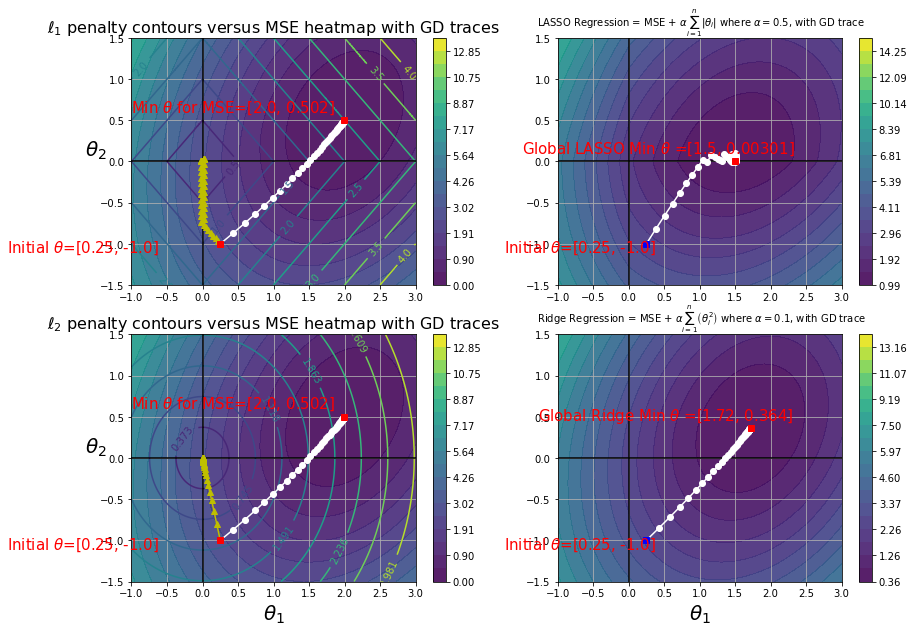

In [2]:
# to plot pretty figures
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

#  l1 versus l2 mixing coefficient

# Do gradient descent for either LASSO or Ridge regression
#     l1 and l2 play the role of alpha the mixing coefficient for the penalty term
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


def plotMSE_Objective_functions(t1a, t1b, t2a, t2b, Xr, yr, t_init):
    # ignore bias term and focus on input feature 1 and input feature 2, x1 and x2
    t1s = np.linspace(t1a, t1b, 500)
    t2s = np.linspace(t2a, t2b, 500)
    t1, t2 = np.meshgrid(t1s, t2s)  # domain of theta1 and theta2, the linear regression parameters
    # np.c_[t1.ravel(), t2.ravel()] .... zip grid t1 and t2 components into pairs of theta1 and theta2
    T = np.c_[t1.ravel(), t2.ravel()]  #pairs of thetas  


    # precalculate and cache the MSE loss for each combination thetas in T (explored in the meshplot)
    # Z
    J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

    # precalculate and cache Norms of the thetas grid points (i.e., of the linear regression coefficients)
    # used for plotting the objective function
    N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
    N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

    # locate the global minimum for the MSE objective function which is: (1.99, 0.50)
    t_min_idx = np.unravel_index(np.argmin(J), J.shape)
    t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

    #startT1 = 0.25
    #startT2 = -1
    #t_init = np.array([[startT1], [startT2]])  #initial values for theta [0.25, -1]

    
    #l1 and l2 play the role of alpha the mixing coefficient for the penalty term
    #
    plt.figure(figsize=(14, 10))
    
    for i, N, l1, l2, title, type_of_LR, eqn in ((0, N1, 0.5, 0, r" where $\alpha=0.5$, with GD trace", "LASSO",
                                            " LASSO Regression = MSE + $\\alpha\\sum_{i=1}^{n}\\left| \\theta_i \\right|$"), 
                                (1, N2, 0,  0.1, r" where $\alpha=0.1$, with GD trace", "Ridge",
                                " Ridge Regression = MSE + $\\alpha\\sum_{i=1}^{n}\\left( \\theta_i^2 \\right)$")):
        JR = J + l1 * N1 + l2 * N2**2  #Objective function surface calculated from cache: MSE + Penalty

        tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
        t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

        # levels for the Z dimension (heatmap, and contour plots) which the objective 
        # function (MSE or LASSO or Ridge)
        # where is the levelsJ for a Vanilla linear regression (J)
        levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J) 
        levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
        levelsN=np.linspace(0, np.max(N), 10)  #[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5]

        #learn a Vanilla linear regression (J); 
        path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)  #
        #learn a Regularized linear regression model
        path_JR = bgd_path(t_init, Xr, yr, l1, l2)  #Regularized: either L1 or L2 
        #learn linear regression using the penalty loss term only (i.e., no MSE component); 
        path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

        # PLOT 1 and 3: plot the component terms of penalized linear regression objective function 
        # separately (i.e., plot MSE filled contours, penalty contour) 
        plt.subplot(221 + i * 2)
        plt.grid(True)
        plt.axhline(y=0, color='k')
        plt.axvline(x=0, color='k')
        plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)             #filled contours for MSE 
        plt.colorbar();
        contours = plt.contour(t1, t2, N, levels=levelsN)              # contours for penalty term
        #plt.colorbar();
        plt.clabel(contours, inline=True, fontsize=10)
        plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)
        if i == 1:
            plt.xlabel(r"$\theta_1$", fontsize=20, rotation=0)

        # plot the gradient paths
        # plot GD path for the MSE term in the linear regression objective.(J);
        plt.plot(path_J[:, 0], path_J[:, 1], "w-o") 
        plt.plot(path_N[:, 0], path_N[:, 1], "y-^") #plot GD path for the penalty loss term only (N);
        plt.plot(t1_min, t2_min, "rs")   #Min for MSE
        plt.plot(t_init[0],t_init[1], "rs")  #start of GD search 
        plt.title(r"$\ell_{}$ penalty contours versus MSE heatmap with GD traces".format(i + 1), fontsize=16)
        plt.axis([t1a, t1b, t2a, t2b])
        
        # Add labels to the plot
        style = dict(size=15, color='red')
        
        plt.text(t_init[0]-3,t_init[1]-0.1, "Initial $\\theta$=["+f"{t_init[0]}, {t_init[1]}]", **style)
        plt.text(t1_min-3, t2_min+0.1, "Min $\\theta$ for MSE=["+f"{t1_min:.3}, {t2_min:.3}]", **style)

  
        print("Global minimum for MSE(theta1, theta2) is located at ", t1_min, t2_min)
        print("and value is", np.round(J[t_min_idx], 7))

        # PLOT 2 and 4 plot the penalized linear regression objective function (i.e., MSE + Penalty)
        plt.subplot(222 + i * 2)
        plt.grid(True)
        plt.axhline(y=0, color='k')
        plt.axvline(x=0, color='k')
        plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
        plt.colorbar();
        #plot GD path for Regularized linear regression: either L1 or L2 
        plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o") 
        plt.plot(t1r_min, t2r_min, "rs") # LASSO or Ridge Min
        plt.plot(t_init[0],t_init[1], "bs")  #start of GD search 
        if i == 1:
            plt.xlabel(r"$\theta_1$", fontsize=20, rotation=0)

        plt.title(eqn + title, fontsize=10)
        plt.axis([t1a, t1b, t2a, t2b])     
        # Add labels to the plot
        style = dict(size=15, color='red')
        plt.text(t_init[0]-2,t_init[1]-0.1, "Initial $\\theta$=["+f"{t_init[0]}, {t_init[1]}]", **style)
        plt.text(t1r_min-3, t2r_min+.1, f"Global {type_of_LR}"+" Min $\\theta$ =["+f"{t1r_min:.3}, {t2r_min:.3}]", **style)
        
    if 1 == 1:
        return

    # bug in new mathplotlib lib
    # the following do not work 
    for subplot in (221, 223):
        plt.subplot(subplot)
        plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    for subplot in (223, 224):
        plt.subplot(subplot)
        plt.xlabel(r"$\theta_1$", fontsize=20)

    plt.show()

# use 3 training examples plot the objective MSE/LASSO/RIDGE functions

def plotSmall_DataSet():
    t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5
    # Training data
    Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]]) # Training data examples
    yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]           # True target
    yr  = yr.reshape(-1,)
    startT1 = 0.25
    startT2 = -1
    t_init = np.array([[startT1], [startT2]])  #initial values for theta [0.25, -1]
    t_init = np.array([startT1, startT2])  #initial values for theta [0.25, -1]

    plotMSE_Objective_functions(t1a, t1b, t2a, t2b, Xr, yr, t_init)

plotSmall_DataSet()

## Regularization: what and how? 

In any supervised learning context we are concerned with making sure our trained models are going to generalize well to unseen data. Regularization techniques help us avoid overfitting. In general they boil down to strategicalling limiting the variance of a model so that we don't accidentally learn patterns in the noise of our data. As we learned early on this reduction in variance will come at the expense of a potential increase in bias. Early stopping is one of the most popular ways to do this but it requires that you are able to set aside a validation set which may not always be feasible, especially with very high dimensional data. Another strategy is to add a penalty term to the loss function when performing your gradient updates. In this section we'll return to the small example from last class to build some intuitions for what this looks like and how this works.

### Demo 1: Small example revisited

Run the provided code below to see how regularized and unregularized gradiet descent compare on our small example. Try changing the hyperparameters one at a time to explore their effects paying particular attention to both the path that the training takes and the location of the "final" model. Use the discussion questions below to help you draw some conclusions based on what you see.

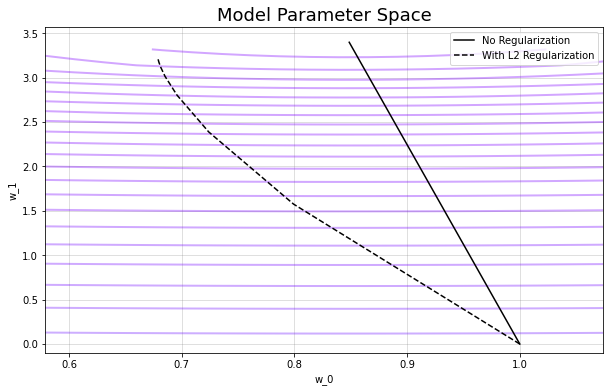

In [13]:
#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
REGULARIZATION_PARAMETER = 0.25
LEARNING_RATE = .25
ORIGINAL_MODEL = [1,0]  #[parameter, bias]
N_STEPS = 10

################### Effect of Regularization Demo #################### 
### small example data
'''
fivePoints.csv
1,2
3,4
5,5
4,3
2,3
'''

X = [1,3,5,4,2]
y = np.array([2,4,5,3,3])

### normalize X 
m = np.mean(X)
sd = np.std(X)
X = [(x-m)/sd for x in X]
### augment x by appending a 1 (the bias term) to each element of X
X = np.column_stack((X, len(X)*[1])) 

### Unregularized Gradient descent training history
no_reg, _ = GDUpdate(X, y, N_STEPS, ORIGINAL_MODEL, LEARNING_RATE)

### Regularized Gradient descent training history
w_reg, _ = GDUpdate(X, y, N_STEPS, ORIGINAL_MODEL, LEARNING_RATE, 
                       reg_type = 'l2', reg_param = REGULARIZATION_PARAMETER)

### plot comparison
compareDescent(X, y, no_reg, w_reg, labels=['No Regularization', 'With L2 Regularization'])

In [14]:
X

array([[-1.41421356,  1.        ],
       [ 0.        ,  1.        ],
       [ 1.41421356,  1.        ],
       [ 0.70710678,  1.        ],
       [-0.70710678,  1.        ]])

 > __DISCUSSION QUESTIONS:__  
 * _How does the regularized training path compare to the unregularized path?_
 * _How do the final regularized models compare to their unregularized counterparts? (Pay particular attention to the weight 0 parameter.) Does this change when you adjust the learning rate?_ 
 * _Given that regularization is something we do to improve the performance of our model does anything seem surprising about the loss where each training path ends?_
 * _How does the regularization parameter affect the training path? How does it affect the final model?_
 * Adjust the learning rate back up to accentuate the zig-zags... take a close look at the direction of the updates in the regularized training path. _Do these updates seem to be going 'down hill'? what conclusions can you draw about the relationship between the regularized model updates and the loss function? -- try to ground your discussion in what you see on the plot rather than theory from other sources._

### Demo 2: Penalizing the loss for our small example.

As you saw in the exercise above, the regularized gradient descent path doesn't exactly seem to follow the principle of taking steps "directly downhill." Under the hood, this is because the regularized training is performing updates based on gradients from a slightly different curve, called the _penalized loss function_ which will (by intention) have a different minimum (one that we think will be more generalizable to unseen data). 

Before diving in to why we think this, let's briefly review the two kinds of penalties commonly used in training linear models. As you saw in chapter 6 of Intro to Statistical Learning:
* __Ridge Regression__ adds an __l2__ penalty term to the OLS loss function:
$$\lambda\sum_{i=1}^m (w_{i})^2$$
* __LASSO Regression__ adds an __l1__ penalty term to the OLS loss function:
$$\lambda\sum_{i=1}^m |w_{i}|$$

Each of these penalty terms includes a hyperparameter, $\lambda$, which allows us to tune how strongly the penalty term changes the shape of the loss curve. It is important to note that by using this penalty term we aren't making a choice to measure _error_ differently, we are creating an entirely different equation to optimize instead. Also note that, unlike the loss function itself, the regularization term is _only_ a function of the weights (not including bias!) and does not depend on the data.

Run the code below to view these penalty terms plotted in 3D. Try changing the regularization parameter to see how this affects the curves (hint, due to autoscaling of the plots you'll need to look carefully at the axes for this). Finally, modify the `REG_TYPE` to see how the OLS loss curve in the second row changes when a penalty term is added.

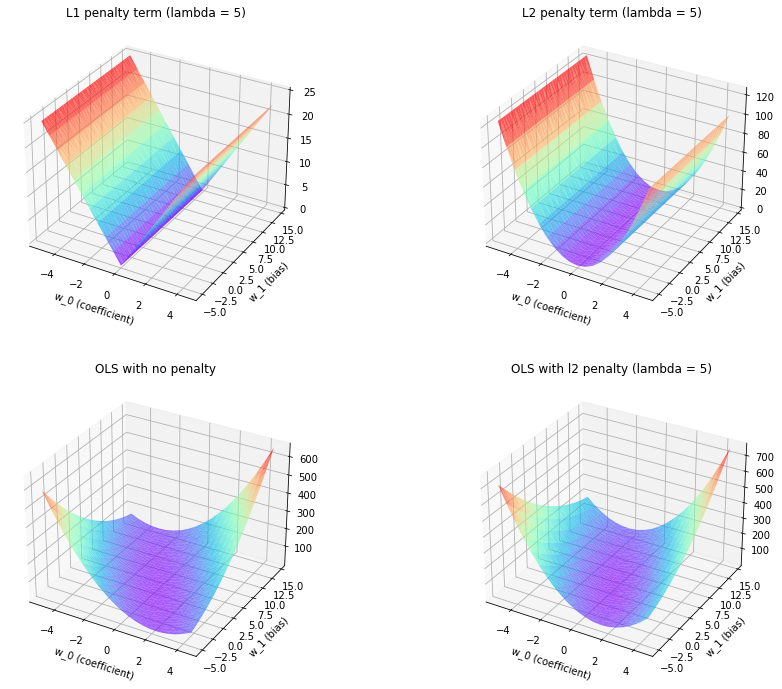

In [15]:
#import helperFunc as hf

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
REGULARIZATION_PARAMETER = 5
REG_TYPE = 'l2'  # try 'l1' or 'l2'

################### Penalized Loss Curves Demo #################### 
### small example data
X = np.array([[1,1],[3,1],[5,1],[4,1],[2,1]])
y = np.array([2,3,4,3,3])
data_domain = [0,5]

### set up the grid for the surface plots
grid = np.mgrid[-5:5:0.5,-5:15:0.5]
size = int(np.product(grid.shape)/2)
models_grid = grid.reshape(2,size)

### plot comparison
compareLossCurves(X, y, reg_type = REG_TYPE, reg_param = REGULARIZATION_PARAMETER, grid = models_grid)

 > __DISCUSSION QUESTIONS:__  
 * _Compare the l1 and l2 penalty curves? Do they have a 'minimum' per se? How can we see in the graph that the regularization term doesn't depend on the bias value, only the coefficient?_
 * _Compare contrast the penalty terms to the OLS loss curve itself. (hint: pay careful attention to the z axis here)_
 * _How does the regularization parameter affect the shape of the penalty curves_
 * Predict what will happen to the OLS curve's shape if we add l1/l2 regularization. Then adjust the `REG_TYPE` to see it in action. Do the results match your expectation?
 * BONUS: what is the connection between these plots and Figure 6.7 on p222 of _Intro to Statistical Learning_.

# Regularization: why?
 As mentioned at the top, the basic motivation for using a penalize loss function is to avoid overfitting. But why do these specific penalties help with that? And why might we chose one or the other depending on the circumstance? Let's take a closer look at some simulated datasets that can help us build intuitions.

### Demo 3: Ridge Regression

Consider the following 10 point dataset:

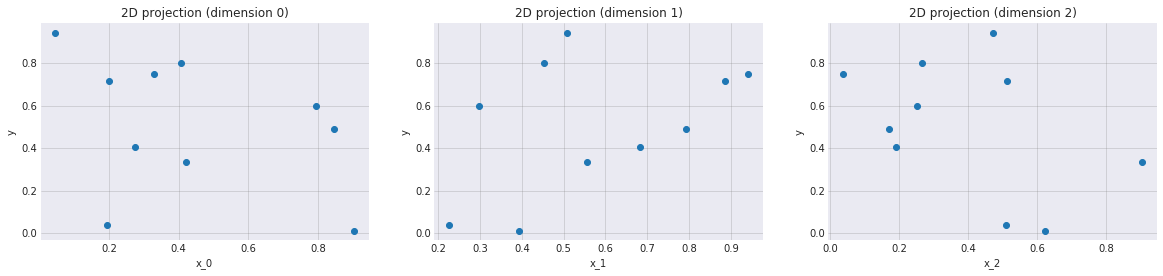

In [12]:
# create simulated dataset - RUN THIS CELL AS IS
np.random.seed(2019)
X = np.random.uniform(size = (10,9))
y = np.random.uniform(size = 10)

# plot the first 3 dimensions vs y
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4))
for i, ax in enumerate((ax1, ax2, ax3)):
    plot2D(ax, X, y, xdim = i)

Each of the plots above represents 2D projection of this dataset (one of the x dimensions plotted with y).

> __DISCUSSION QUESTIONS:__  
 * _Examine the code that generates this dataset. How many dimensions does the data have? (feel free to add an extra cell to take a look at $X$ if you like)_ 
 * _Given what you observe in the plot and what you know about how the data were generated, how well would you expect a linear model to fit this data? what would it look like?_ 

The code below fits a regularized and unregularized model to the dataset generated above and plots a 2D view of the resulting models in the same projection as above.

OLS   coefficients: -0.47  0.34  -0.16  -0.76  0.82  0.91  1.04  0.62  -1.34
Ridge coefficients: -0.02  0.01  -0.01  0.0  -0.01  0.02  0.02  -0.01  -0.0


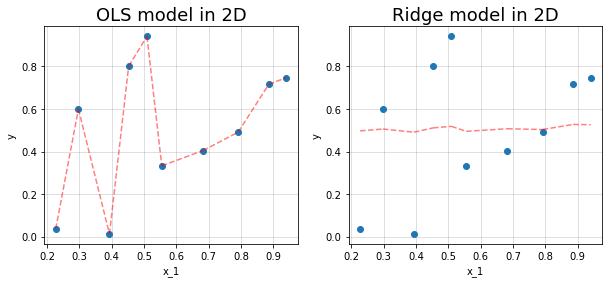

In [27]:
from sklearn.linear_model import LinearRegression, Ridge
import numpy as np

#################### Demo Parameters #################### 
# TRY CHANGING THESE
REGULARIZATION_PARAMETER = 20
PROJECTION_DIMENSION = 1
nPOINTS = 10
nDim = 9

################### Penalized Loss Curves Demo #################### 
### data (same as above unless you change the number of points / dimensions)
np.random.seed(2019)
X = np.random.uniform(size = (nPOINTS,nDim))
y = np.random.uniform(size = nPOINTS)

### fit an OLS model and a ridge model using sklearn (9 input variables)
ols = LinearRegression().fit(X,y)
ridge = Ridge(alpha = REGULARIZATION_PARAMETER).fit(X,y)

### print out the model parameters side by side
print('OLS   coefficients: ' + '  '.join([str(round(w,2)) for w in ols.coef_]))
print('Ridge coefficients: ' + '  '.join([str(round(w,2)) for w in ridge.coef_]))

### plot comparison in 2D
labels=['OLS model in 2D', 'Ridge model in 2D']
compare2Dprojections(X, y, xdim = PROJECTION_DIMENSION, models = [ols, ridge], labels = labels)


> __DISCUSSION QUESTIONS:__  
 * _Compare the coefficients of the regularized & unregularized models. What do you notice? How does changing the regularization parameter affect the relationship between the OLS and Ridge coefficients_ 
 * _Given what you know about this dataset, is there anything surprising about the OLS model as plotted in the 2D projection? What might be going on here?_
 * _Compare the OLS and Ridge models based on their plots. Which model is overfitting?_
 * _Try a few different regularization parameter and projection dimensions... how does this affect the overfitting problem?_
 * _If time permits, try increasing the number of data points... how does this affect the overfitting problem?_
 
__Notes:__
* _This demo exercise was inspired by one of the examples presented in_ [these lecture notes by Wessel N. van Wieringen, VU University](https://www.statisticshowto.com/wp-content/uploads/2017/07/lecture-notes.pdf) _which the author has published under a creative commons license._
* _The sklearn package has very nice alternalte approach to illustrating how ridge regression reduces the variance of the linear model that gets fit. If time permits, check it out_ [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py).

### Demo 4: Lasso Regression
Consider the following 10 point dataset.

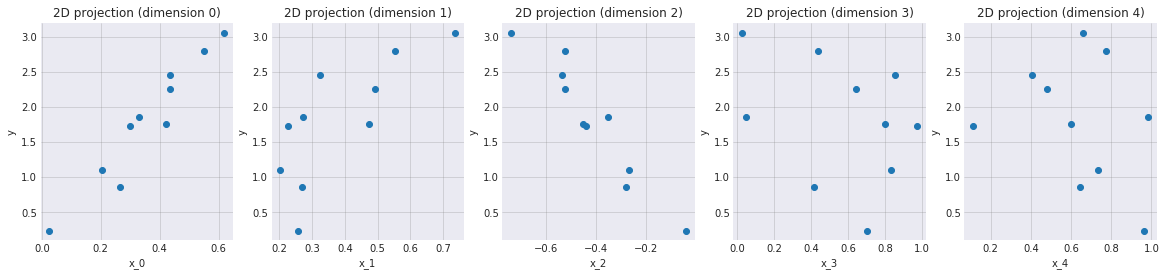

In [9]:
# create simulated dataset - RUN THIS CELL AS IS
np.random.seed(2)
N = 10
x0 = np.random.uniform(size = N) #uniform(low=0.0, high=1.0, size=None)
x1 = x0 + np.random.normal(0,0.1,N)
x2 = - x0 + np.random.normal(0,0.1,N)
x3thru9 = np.random.uniform(size = (N,7))
X = np.hstack([np.array([x0,x1,x2]).T, x3thru9])
y = 5*x0 + np.random.normal(0,0.2,N)

# plot the first dimension vs y
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,4))
for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
    plot2D(ax, X, y, xdim = i)

> __DISCUSSION QUESTIONS:__  
 * _Examine the code that generates this dataset. How many dimensions does the data have? (feel free to add an extra cell to take a look at $X$ if you like)_ 
 * _Given what you observe in the plot and what you know about how the data were generated, how many of the features (dimensions) are going to be helpful in creating a linear model? which ones?_
 * _Based on what you saw in the last demo, what are the risks associated with a model that includes all 5 features?_

The code below fits ols, ridge and lasso models to the dataset generated above. Use the code provided to explore the effects of lasso regularization. Can you identify the key difference between lasso and ridge?

OLS   coefficients: 10.87  -1.46  4.83  0.62  -0.8  0.33  -0.72  1.66  -0.24
Ridge coefficients: 1.74  1.57  -1.11  -0.17  -0.41  -0.14  -0.16  -0.01  0.12
Lasso coefficients: 2.02  0.06  -0.72  0.0  -0.0  -0.0  0.0  0.0  0.0


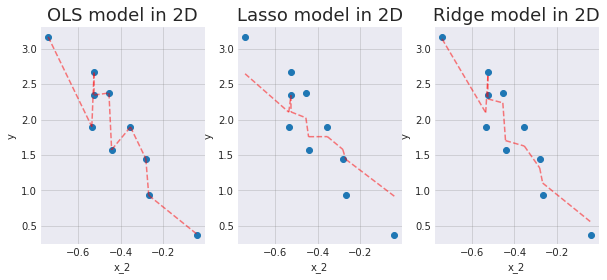

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#################### Demo Parameters #################### 
# TRY CHANGING THESE
REGULARIZATION_PARAMETER = 0.05
PROJECTION_DIMENSION = 2
nPOINTS = 10
nDim = 9

################### Penalized Loss Curves Demo #################### 
### data (same as above)
np.random.seed(2)
x0 = np.random.uniform(size = nPOINTS)     # uniform(low=0.0, high=1.0, size=None)
x1 = x0 + np.random.normal(0,0.1,nPOINTS)  # normal
x2 = - x0 + np.random.normal(0,0.1,nPOINTS)  # x2 is x0 + noise
x3thruN = np.random.uniform(size = (nPOINTS,nDim - 3))
X = np.hstack([np.array([x0,x1,x2]).T, x3thruN]) 
y = 5*x0 + np.random.normal(0,0.2,nPOINTS)

### fit an OLS model and a ridge model using sklearn
ols = LinearRegression().fit(X,y)
ridge = Ridge(alpha = REGULARIZATION_PARAMETER).fit(X,y)
lasso = Lasso(alpha = REGULARIZATION_PARAMETER).fit(X,y)

### print out the model parameters side by side
print('OLS   coefficients: ' + '  '.join([str(round(w,2)) for w in ols.coef_]))
print('Ridge coefficients: ' + '  '.join([str(round(w,2)) for w in ridge.coef_]))
print('Lasso coefficients: ' + '  '.join([str(round(w,2)) for w in lasso.coef_]))

### plot comparison in 2D
labels=['OLS model in 2D', 'Lasso model in 2D', 'Ridge model in 2D']
compare2Dprojections(X, y, xdim = PROJECTION_DIMENSION, models = [ols, lasso, ridge], labels = labels)

> __DISCUSSION QUESTIONS:__  
 * _Examine the ols, lasso and ridge regression coefficients. How do these three models differ?_ 
 * _Based on the plots, does lasso seem like a better model? What might be the benefits to using lasso despite the seemingly worse fit?_
 * _Try changing the regularization parameter, what do you notice about the difference between "reasonable" looking regularization terms for ridge and lasso?_
 
 __Notes:__
 * _ISL is the best reference for understanding LASSO since Tibshirani was one of its main architects... however we also recommend the following_ [paper by Andrew Ng](https://icml.cc/Conferences/2004/proceedings/papers/354.pdf). _And these accompanying_ [lecture slides](http://cseweb.ucsd.edu/~elkan/254spring05/Hammon.pdf) _may also be of interest._

# Why don't we penalize the bias term?


<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week07/dont-shrink-the-intercept.png' style="width:90%;">


# Converging Faster

Regularization addresses the issue of trying to make sure that our gradient descent will end up at a minimum point that represents a model that generalizes well. However we should also be concerned with optimizing the speed (i.e. number of steps/epochs/updates needed) at which GD converges. In general we do this by being smart about the learning rate.

#### Some Common Techniques to improve Gradient Descent's speed


1. __Slow down as we get closer to a minimum__ 
> _GD does this naturally because the magnitude of the update vector will get smaller as the slopes get shallower around a minimum, however we can help it along strategically by reducing lambda as we perceive that our traing updates are getting smaller._ (look up: "__Adagrad__", "__Adadelta", "__RMSprop__")

2. __Using momentum__ : 
> _Take bigger updates when the direction of the next update is similar to the last one._  (look up: "__Nesterov accelerated gradient__").

3. __Perform different size updates for each parameter__: 
> _This is particularly helpful for unnormalized data but can help in general as some of your parameters may not contribute much to improving the model performance_ (look up: "__Adam__" (adaptive moment estimation) and "__AdaMax__")

3. __Train each parameter independently__ (Coordinate Descent): 
> _This is a newer approach that has interesting implications for parallelized SGD._

The following image comes from this [article by Sebastian Ruder](http://ruder.io/optimizing-gradient-descent/) ([arxiv link])(https://arxiv.org/pdf/1609.04747.pdf) which is a good starting point if you want to dive into any of these GD variants more deeply.


<img src='https://raw.githubusercontent.com/UCB-w261/w261-environment/master/notebook-images/Week07/saddle_point_evaluation_optimizers.gif' style="width:50%;">



# [Optional]: If all else fails: numerical approximation

With more complicated Loss Functions we may run the risk of making a mistake when computing the gradient. In some cases it may even be impossible to compute an analytical gradient. In this section we'll look at a simple way to check that our gradient function is right. This "numerical approximation of the gradient" can be used as an alternative to perform gradient updates.

__(Numerical Approximation Method)__

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simply throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

The code below uses a dataset from sklearn to compare this approximation to the true gradient using a dataset from sklearn & some helper classes in an attached file.

In [ ]:
#!/opt/anaconda/bin/python
"""
Helper classes for homegrown linear regression & numerical approximation
of the gradient.
"""

import numpy as np

class BasicLinearRegressionHomegrown(object):

    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [],
                        "coef": [],
                        "intercept": [],
                        "grad": []}

    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient

    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())

            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)

            # do gradient step
            self._theta -= alpha * grad

    def fit(self, X, y, max_iter, alpha):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        # do full gradient descent
        self._gd(X, y, max_iter, alpha)

        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse

    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):

    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []

    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        alpha = 0.001
        for i in range(len(x)):
            h = np.zeros(len(x))
            h[i] += alpha
            grad_num[i] = (f(x + h) - f(x)) / alpha

        return grad_num

    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation
                               of the gradient
        """

        grad_num = np.zeros(X.shape[1])

        def f(a):
            pred = np.dot(X, a)
            error = pred - y
            mse = np.mean(error ** 2)
            return mse


        grad_num = self._gradient_approximation(f, self._theta)

        return grad_num

    def _gd(self, X, y, max_iter, alpha):
        """
        Runs GD and logs error, weigths, gradient and
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())

            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)

            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)

            self._theta -= alpha * grad

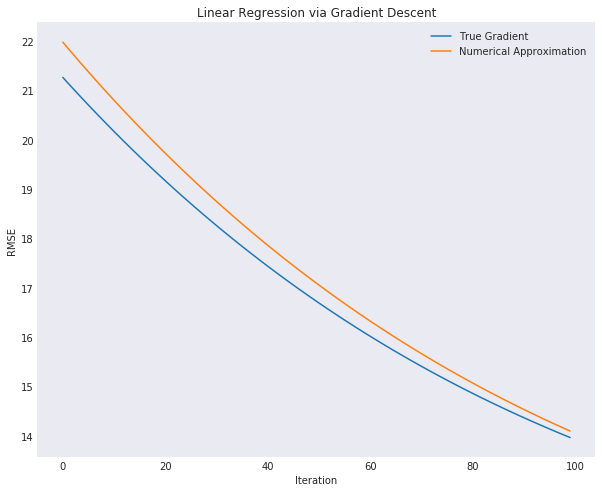

In [17]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the data & take a look.
boston = load_boston()
#print(boston.DESCR) # -- uncomment to run

# Create data frame & test/train split.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create & fit models with & without numerical approximation
model_homegrown = BasicLinearRegressionHomegrown()
model_homegrown.fit(X_train, y_train, max_iter=100, alpha=0.001)
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()
model_homegrown_check_grad.fit(X_train, y_train, max_iter=100, alpha=0.001)

# plot the training curve
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="True Gradient")
plt.plot(model_homegrown_check_grad.history["cost"], label="Numerical Approximation")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend()
plt.show()

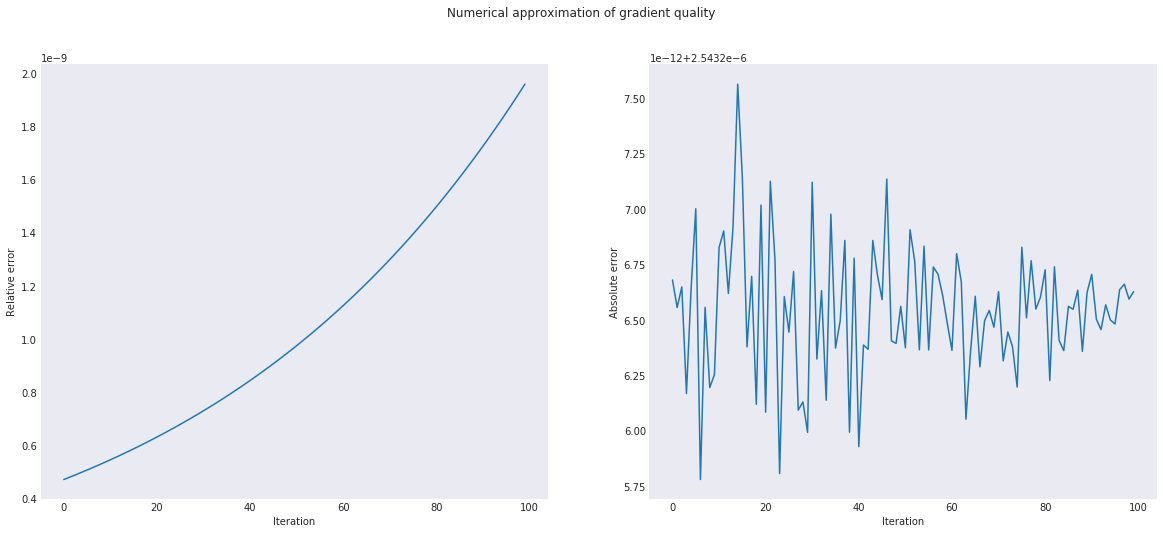

In [18]:
# compare the RMSE & gradients for all 100 iterations
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

# Regularized linear regression in Spark on a DataProc cluster

Note: If you get an error with launching Spark, please restart your cluster.

In [21]:
# (RUN THIS CELL AS IS)
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "Lab7_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/07 22:42:28 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/06/07 22:42:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/06/07 22:42:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/06/07 22:42:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [25]:
# get Spark Session info (RUN THIS CELL AS IS)
spark #NOTE the Spark UI link provided below as output from this command does not work. See next section on how to get that working.

## OPTIONAL:  to view the Spark UI (jobs and stages) 

Getting access to Spark UI, you will need to create a tunnel from DataProc via the CloudShell. Please follow all three steps depicted below (starting with running the following code cell). 

In [9]:
# Optional  to view the Spark UI (jobs and stages) 
# Access staging bucket and see whats there
# (RUN THIS CELL AS IS)
import os
print(f"STAGING_BUCKET location: {os.getenv('STAGING_BUCKET')}")
!gsutil ls -lh {os.getenv("STAGING_BUCKET")}notebooks/jupyter
# GC zone
print(f'STAGING_BUCKET: {os.getenv("STAGING_BUCKET")}')
ZONE = "-".join(os.getenv("STAGING_BUCKET").split("-")[2:4])
print(f"ZONE: {ZONE}")


ui_port = spark._repr_html_().split(".internal:")[-1].split('"')[0]
print("Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell and run as shown in the screenshot below. \nAnd click on the PREVIEW ON PORT 8080 menu option .")
f'gcloud compute ssh w261-m --zone {ZONE}-b --ssh-flag "-L 8080:localhost:{ui_port}"' 
# expect 'gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:37649"'

STAGING_BUCKET location: gs://dataproc-staging-us-central1-913378501339-ychjbide/
       0 B  2022-05-04T22:04:16Z  gs://dataproc-staging-us-central1-913378501339-ychjbide/notebooks/jupyter/
                                 gs://dataproc-staging-us-central1-913378501339-ychjbide/notebooks/jupyter/snapshots/
                                 gs://dataproc-staging-us-central1-913378501339-ychjbide/notebooks/jupyter/student-workspace/
                                 gs://dataproc-staging-us-central1-913378501339-ychjbide/notebooks/jupyter/ucb-w261-master/
TOTAL: 1 objects, 0 bytes (0 B)
STAGING_BUCKET: gs://dataproc-staging-us-central1-913378501339-ychjbide/
ZONE: us-central1
Copy the following command (and swap out the ZONE for your cluster zone) to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .


'gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:4040"'

## Review gradient descent-based linear regression learning algorithm 


$$ \hat{y} = mx + b $$

Note we $\hat{y}$ as to represent a prediction or estimate of $f(x)$

$$ error_i = \hat{y_i}  - y_i$$


## Linear Regression model prediction (in vectorized form)

$$
\hat{y} = h_{\mathbf{\theta}}(\mathbf{X}) = \mathbf{X} \cdot \mathbf{\theta}  
$$


**MSE cost function for a Linear Regression model**

$
\text{MSE}({\mathbf{\theta}}; \mathbf{X}, \mathbf{y}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{( \mathbf{x}^{(i)}\cdot \mathbf{\theta} - y^{(i)})^2}
$



**Partial derivatives notation :**

$\frac{\partial}{\partial \theta_j} \text{MSE}(\mathbf{\theta})$


**Partial derivatives of the cost function with respect a single input $\theta_j$**

$
\dfrac{\partial}{\partial \theta_j} \text{MSE}(\mathbf{\theta}) = \dfrac{2}{m}\sum\limits_{i=1}^{m}( \mathbf{x}^{(i)} \cdot \mathbf{\theta} - y^{(i)})\, x_j^{(i)}
$


**Gradient vector of the cost function vectorized**

$
\begin{aligned}
\nabla_\text{MSE}(\mathbf{\theta}) &=
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\mathbf{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\mathbf{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\mathbf{\theta})
\end{pmatrix}\\
 &= \dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})
\end{aligned}
$


**Gradient Descent step**

$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_\text{MSE}(\mathbf{\theta})
$




In [10]:
# Simple linear regression
#           X             y
X_y =  [[  0.39050803,  -1.20623543],
       [  1.72151493,  13.57377242],
       [  0.82210701,   5.50818095],
       [  0.35906546,  -2.19996366],
       [ -0.61076161,  -3.90958845],
       [  1.1671529 ,  11.12900159],
       [ -0.49930231,  -3.63685934],
       [  3.13418401,  22.71362238],
       [  3.70930208,  25.53291143]]

data_rdd = sc.parallelize(X_y).cache()
# The true y = 8x - 2.
#.  [b, m]
W = [-2, 8]  # model
wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
#                                       (               Xw             -     y)**2
# gradient  (Xw - y) X
MSE  = data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()
print(f"MSE:{MSE}")

MSE:5.8327308811790175


In [11]:
# gradient = (Xw - y) X
# gradient  =    X         *        (               Xw             -     y)**2
gradient  = data_rdd.map(lambda d: np.append(1,d[:-1])  *    (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean() 
print(f"gradient:{gradient}")
#np.c_[1, d[:-1]]
#np.dot    OR  np.append(1,d[:-1]) @ W

gradient:[-0.43940865  0.64297919]


In [12]:
import numpy as np

def generate_data(w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[1] + w[0] + noise)
    X_y = np.c_[x, y]
    return X_y

# The true y = 8x - 2.  giving a weight vector of [-2, 8]
X_y = generate_data([-2, 8], 100)
X_y[:10]

array([[ 0.39050803, -1.20623543],
       [ 1.72151493, 13.57377242],
       [ 0.82210701,  5.50818095],
       [ 0.35906546, -2.19996366],
       [-0.61076161, -3.90958845],
       [ 1.1671529 , 11.12900159],
       [-0.49930231, -3.63685934],
       [ 3.13418401, 22.71362238],
       [ 3.70930208, 25.53291143],
       [-0.93246785, -7.35083934]])

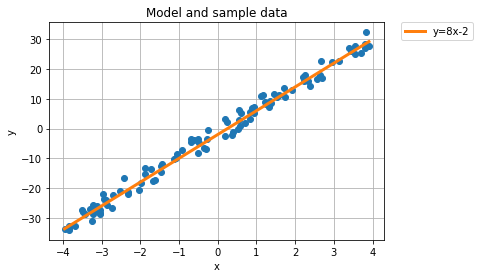

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model(samples, model, name, title=None):
    """
    Plot a model the and samples observed from the population.
    INPUT:  samples    - numpy array of points (x, y)
            model      - [W, b] where Y = Wx + b
            title      - (optional) figure title
    """

    # create plot
    fig, ax = plt.subplots()

    # plot samples
    ax.plot(X_y[:,0], X_y[:,1],'o')
    domain = [min(X_y[:,0]), max(X_y[:,0])]

    # plot model line
    w0 , w1 = model[0], model[1]
    yvals = [w1*x + w0 for x in domain]
    ax.plot(domain, yvals, linewidth=3, label=name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    # title
    if title:
        plt.title(title)
# The true y = 8x - 2.
model = [-2, 8]

# generate samples
X_y = generate_data(model, 100)

plot_model(X_y, model, 'y=8x-2', 'Model and sample data')


In [14]:
X_y_rdd = sc.parallelize(X_y).cache()
X_y_rdd.take(5)

[array([ 0.39050803, -1.20623543]),
 array([ 1.72151493, 13.57377242]),
 array([0.82210701, 5.50818095]),
 array([ 0.35906546, -2.19996366]),
 array([-0.61076161, -3.90958845])]

## compute LR MSE

In [15]:
def compute_LR_MSE(data_rdd, W=[0,0]):
    """ compute the MSE  for the provided linear regression model W over the data RDD where each record is of the form (X, y)
    INPUT:  data_rdd    -  an RDD where each record of the form  (X,y) = data[:-1], data[-1]
            W           -  a vector of weights, where W[0] corresponds to the y-intercept
            
    """

    wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
    #                                                     ( Xw                    -     y)**2
    return data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean()

model = [0,0]
mean_squared_error = compute_LR_MSE(X_y_rdd, model)
print(f"the MSE of the  model is {model} is {mean_squared_error:.5}")

model = [-2,8]
mean_squared_error = compute_LR_MSE(X_y_rdd, model)
print(f"the MSE of the  model {model} is {mean_squared_error:.5}")

#the MSE of the  model [0, 0] is 354.35
#the MSE of the  model [-2, 8] is 4.119

the MSE of the  model is [0, 0] is 354.35
the MSE of the  model [-2, 8] is 4.119


In [16]:
# gradient = (Xw - y) X
# gradient  =    X         *        (               Xw             -     y)**2
gradient  = X_y_rdd.map(lambda d: np.append(1,d[:-1])  *    (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean() 
print(f"gradient:{gradient}")


gradient:[-0.38466869  0.16759204]


## Ridge linear regression

Modify the following code to calculate:
* the Ridge least squares loss when $\lambda$, the mixing coefficient for the regularization term, is 1 
* the gradient for ridge least squares loss function when $\lambda$, the mixing coefficient for the regularization term, is 1 



### Ridge Linear Regression review
Regularization is a way of penalizing the model for excessive complexity, and this helps reduce the risk of  overfitting. There are many ways of doing regularization but these two are the major ones:

* **Linear regression L2-regularization:**
$$
f(\mathbf{\theta}, b) = \frac{1}{m}\sum_{i=1}^{m}\left[ (\mathbf{\theta}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \left[ \sum_{j=1}^{n}w_j^2 \right]
$$
or in matrix/vectorized and augmented form:
$$
f(\mathbf{\theta}, b) = \|\text{X}\cdot\mathbf{\theta}  - \mathbf{y}\|_2^2 + \lambda \|\mathbf{\theta'}\|_2^2
$$
$$
f(\mathbf{\theta}, b) = \|\text{X}\cdot\mathbf{\theta}  - \mathbf{y}\|_2^2 + \lambda \mathbf{\theta'}\cdot\mathbf{\theta'}
$$

where
$$
\theta' \text{denotes } \theta \text{ with } \theta[0] = 0, \text{i.e., y-intercept is set to zero}
$$



**Gradient vector of the ridge regression cost function vectorized**

$$
\begin{aligned}
\nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta}) &=
 \left[\dfrac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + 2*\lambda \mathbf{\theta'}\\
 &= \left[\dfrac{1}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \mathbf{\theta} - \mathbf{y})\right] + \lambda \mathbf{\theta'}
\end{aligned}
$$

where
$$
\theta' \text{denotes } \theta \text{ with } \theta[0] = 0, \text{i.e., y-intercept is set to zero}
$$

**Gradient Descent step**

$$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}\, \text{RidgeMSE}(\mathbf{\theta})
$$

In [33]:
# Simple linear regression
#           X             y
X_y =  [[  0.39050803,  -1.20623543],
       [  1.72151493,  13.57377242],
       [  0.82210701,   5.50818095],
       [  0.35906546,  -2.19996366],
       [ -0.61076161,  -3.90958845],
       [  1.1671529 ,  11.12900159],
       [ -0.49930231,  -3.63685934],
       [  3.13418401,  22.71362238],
       [  3.70930208,  25.53291143]]

data_rdd = sc.parallelize(X_y).cache()
# The true y = 8x - 2.
#.  [b, m]
W = [-2, 8]  # model
llambda = 1  # the mixing coefficient for the regularization term in Ridge loss
wBroadcast = sc.broadcast(W)  # make available in memory as read-only to the executors (for mappers and reducers)
#                                       (               Xw             -     y)**2

MSE  = data_rdd.map(lambda d: (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])**2).mean() 
MSE_ridge = MSE  +  ...

print(f"     MSE:{MSE}\nRidge MSE:{MSE_ridge}")

     MSE:5.8327308811790175
Ridge MSE:69.83273088117902


In [22]:
# gradient = (Xw - y) X
# gradient  =    X         *        (               Xw             -     y)**2
gradient  = data_rdd.map(lambda d: np.append(1,d[:-1])  *    (np.dot(np.append(1, d[:-1]), wBroadcast.value) - d[-1])).mean() 
llambda = 1  # the mixing coefficient for the regularization term in Ridge loss

ridge_gradient = gradient + ...
print(f"MSE gradient   :{gradient} \n ridge gradient:{ridge_gradient}")
#np.c_[1, d[:-1]]
#np.dot    OR  np.append(1,d[:-1]) @ W

MSE gradient   :[-0.43940865  0.64297919] 
 ridge gradient:[-0.43940865  8.64297919]


# Introduction to Maximum-Likelihood Estimates
So far we have studeied different probabilistic classifiers such as Naive Bayes classifiers, and  logistic regression classifiers.  In this section will derive from scratch the the gradient descent update rule for learning a logistic regression model.

## Deriving  Maximum-Likelihood Estimates

Consider a training data set of the form ${(X^{(1)}, y^{(1)}, \dots, (X^{(m)}, y^{(m)})}$, where each $X^{(i)}$ is a an $n$-dimensional vector, and $y^{(i)}$ is the true label (aka ground truth label) of the corresponding example. Given a (learnt) logistic regression model one can calculate a  probability for the ground truth class of each training example (as was defined above and presented here in context for convenience) as follows:


$$
\begin{aligned} 
p(Y = y^{(i)} \mid x^{(i)}_1, \dots, x^{(i)}_n) &=p(Y = y^{(i)} \mid x^{(i)}_1, \dots, x^{(i)}_n) 
\end{aligned}
$$

Let's assume the training data are independently sampled from the same distribution; this is known as the *iid assumption*, which stands for “independent and identically distributed”. Given an IID dataset, we can estimate the joint probability of the dataset as a function of the parameters of the learnt model as follows using the class  probability associated with the ground truth class of each training example:

$$\begin{aligned}
P(D|\theta) &= \prod_{i = 1}^m p(Y = y^{(i)} \mid x^{(i)}_1, \dots, x^{(i)}_n) 
\end{aligned} $$

We refer to this joint probability distribution, $P(D|\theta)$, as the **(conditional) likelihood  $L(\theta)$**.  Here for convenience we use  $\theta$ to refer to the vector (for the binary classifier and a matrix for an n-ary classifier) of model coefficients, and bias term for all parameters $i\in{1, \dots, n}$.$i\in{1, \dots, n}$. For multinomial classidier,  $\theta$ will be an $n \times \times  K$ matrix for features $i\in{1, \dots, n}$ and classes $j \in [1,\dots, K]$. *The likelihood is a function of the parameter values, and the training examples.* We usually work with the **log likelihood** (because of numerical underflow issues), which is given by:

$$\begin{aligned}
LL(\theta) \triangleq \log P(D|\theta) &= \sum_{i = 1}^m log P(y^{(i)} | x^{(i)}) \\
\end{aligned} $$

Here $\triangleq$ denotes *"is defined by"*. This decomposes into a sum of terms, one per example. Generally, we wish to maximize this quantity, i.e., for each example, we would desire for $p(Y = y^{(i)} \mid x^{(i)}_1, \dots, x^{(i)}_n)$ to be maximum (or as close to 1 as possible for the ground truth class). This then leads to Maximum Likelihood Estimation (MLE) objective function that is given by:

$$ {\hat {\theta }}_{MLE}= \arg\max_{\theta; D}\sum_{i = 1}^m log P(y^{(i)} | x^{(i)}) $$


Since most optimization algorithms and software implementations are designed to minimize
objective functions,  the MLE objective function is flipped to a minimization problem, commonly known as the (conditional) negative log likelihood or NLL as follows:


$${NLL ({\theta }; D)}  \triangleq -\log p(D|\theta) = -  \sum_{i = 1}^m log P(y^{(i)} | x^{(i)}) $$

Minimizing this will also give the maximum likelihood estimate (MLE) of the model parameters. 


$$ {\hat {\theta }}_{MLE}= \arg\min_{\theta; D} - \sum_{i = 1}^m log P(y^{(i)} | x^{(i)}) 
\label{eq:MLE_cond} \tag{1}
$$

In Equation $\eqref{eq:MLE_cond}$, Vector $\theta$,  in the case of   Naive Bayes, could refer to the model parameters $Pr(C_j)$ and $Pr(x_{ij|C = y_j})$ for $j \in [1,\dots, K]$ and $i\in{1, \dots, n}$. In the case of logistic regression, $\theta$ would correspond to the the vector of coefficients and bias term for a binary classification proble,.

As an aside, if the model is unconditional (unsupervised, as in, say,  the case of the EM clustering algorithm), the MLE becomes:

$$ {\hat {\theta }}_{MLE}= \arg\min_{\theta; D} - \sum_{i = 1}^m log P(x^{(i)}, \theta) 
\label{eq:MLE_uncond} \tag{2}
$$

In summary, [maximum likelihood estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is a method of estimating the parameters of a model (of probability distributions in the case of Naive Bayes machine learnt model) by maximizing a likelihood function, so that under the assumed statistical model the observed data is most probable (i.e., the joint probability of the data is highest given by the likelihood function). The model, a point in the parameter space, that maximizes the likelihood function is called the maximum likelihood estimate. The logic of maximum likelihood is both intuitive and flexible, and as such the method has become a dominant means of statistical inference (think machine learning).

Most machine learning algorithms can be reframed probabilistically to leverage the maximum likelihood estimation framework. If the likelihood function is differentiable, the derivative test for determining minima (or maxima) can be applied. In some cases, the first-order conditions of the likelihood function can be solved explicitly in closed form. For instance:

* The normal eqaution is a closed form solution to the ordinary least squares estimator that maximizes the likelihood of the linear regression model. 
* The estimates for the class prior and the class conditionals in the case of learning a Naive Bayes model are a closed form solution that maximizes the likelihood of the Naive Bayes model. 
  * In the case of Naive Bayes,  Maximum-likelihood training can be done by evaluating a closed-form expression  which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.
* Logistic regression and deep learning frameworks for classification also fall under the maximum likelihood family (more that in next module).

Under some circumstances, however, numerical methods will be necessary to find the optimum of the likelihood function. 

From the vantage point of Bayesian inference (more on this later), MLE is a special case of maximum a posteriori estimation  (MAP) that assumes a uniform  prior distribution  of the parameters. In frequentist inference , MLE is a special case of an extremum estimator, with the objective function being the likelihood.

# Learning logistic regression classifcation models via a maximum likelhood loss function


The simplest kind of classification problem is binary classification, when there are only two categories, so let's start there. Let's call our two categories the positive class  𝑦𝑖=1  and the negative class  𝑦𝑖=0  (another common way of defining the labels are  𝑦𝑖=±1 ). Even with just two categories, and even confining ourselves to linear models, there are many ways we might approach the problem. 

At a high level, building a good classifier boils down to  separating the data points along class lines. Additionally, it may be useful to provide a probability. Here the idea is to train *probabilistic classifiers* which estimate, for each data point $\boldsymbol{x}$, the *conditional probability* $\mathbb{P}(y|\boldsymbol{x})$ that it belongs to class $y$. 

In this section will derive from scratch the the gradient descent update rule for learning a logistic regression model.


## Binary classifiers: logistic regression models

Recall that in linear regression, the goal is to make predictions of the form

$$ \hat{y} = \boldsymbol{x}^T \boldsymbol{w} + b, $$

where $\hat{y},b\in\mathbb{R}$ and $\boldsymbol{w},\boldsymbol{x}\in\mathbb{R}^n$. In contrast, in the case of classification, the  interest is in asking the question *"what is the probability that example $\boldsymbol{x}$ belongs to the positive class?"* A regular linear model is a poor choice here because it can output values greater than $1$ or less than $0$. To coerce reasonable answers from our model (in the $[0, 1]$ interval),  the linear regression model can be modified  slightly, by running the linear function through a sigmoid activation function $\sigma$:

$$ \hat{y} =\sigma(\boldsymbol{x}^T \boldsymbol{w} + b). $$

The sigmoid function $\sigma$, sometimes called a squashing function or a *logistic* function - thus the name logistic regression - maps a real-valued input to the range 0 to 1. Indeed, the logistic function $\sigma(z)$ is a good choice since it has the form of a probability, i.e. $\sigma(-z)=1-\sigma(z)$ and $\sigma(z)\in (0,1)$ as $z\rightarrow \pm \infty$. Here $z$ can be viewed as the perpendicular distance from a data point to a class hyperplane in the binary case. If target labels are set $y\in(0,1)$ this will result in the following:  

\begin{equation}
\begin{aligned}
\mathbb{P}(y=1|z) & =\sigma(z)=\frac{1}{1+e^{-z}}\\
\mathbb{P}(y=0|z) & =1-\sigma(z)=\frac{1}{1+e^{z}}\\
\end{aligned}
\end{equation}


which can be written more compactly as $\mathbb{P}(y|z)  =\sigma(z)^y(1-\sigma(z))^{1-y}$. The logistic function can be visualized as follows:

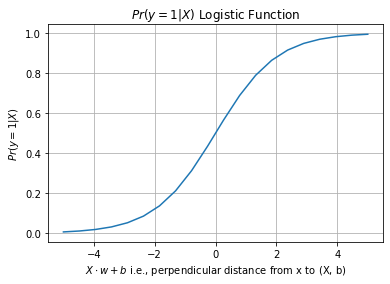

In [32]:
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

plt.plot(np.linspace(-5,5, 20), sigmoid(np.linspace(-5,5, 20)))
plt.xlabel("$X\cdot w + b$ i.e., perpendicular distance from x to (X, b)")
plt.ylabel("$Pr(y=1 | X)$")
plt.title("$Pr(y=1 | X)$ Logistic Function")
plt.grid()

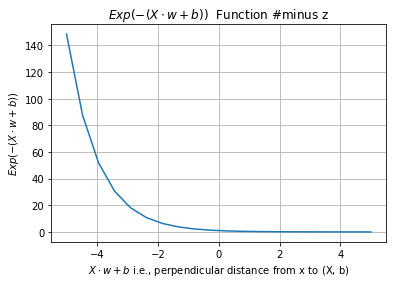

In [31]:
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def my_exp(z):
    return np.exp(-z)

plt.plot(np.linspace(-5,5, 20), my_exp(np.linspace(-5,5, 20)))
plt.xlabel("$X\cdot w + b$ i.e., perpendicular distance from x to (X, b)")
plt.ylabel("$Exp(-(X\cdot w + b$))")
plt.title("$Exp(-(X\cdot w + b$))  Function #minus z")
plt.grid()

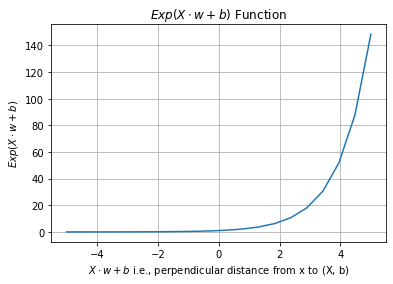

In [30]:
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def my_exp(z):
    return np.exp(z)

plt.plot(np.linspace(-5,5, 20), my_exp(np.linspace(-5,5, 20)))
plt.xlabel("$X\cdot w + b$ i.e., perpendicular distance from x to (X, b)")
plt.ylabel("$Exp(X\cdot w + b$)")
plt.title("$Exp(X\cdot w + b$) Function")
plt.grid()

Note, in the case of the logistic function, that an input of $0$ gives a value of $0.5$. The decision boundary between positive and negative examples when the predicted probabilty of 0.5. So a probability prediction of  $0.5$ or greater would result in a positive label $+1$ been assigned, otherwise a negative label $0$ is assigned. Alternatively, if all that is needed is a class label (i.e., without a probability) then the sign of $\boldsymbol{w}^T \boldsymbol{x} + b$ can be used directly as was presented previously. Formally, in (binary) classification problems one aims at finding a classification rule (also called decision rule) which is a binary valued function on the input space $c:\mathcal{X}\rightarrow\{0,1\}$ (in this example $\mathcal{X}=\mathbb{R}^n$). However, direct minimization of the classification error is not computationally feasible mostly because the classification loss is not convex (to be discussed later). In practice, one looks for a real valued (rather than binary valued) function $f:\mathcal{X}\rightarrow \mathbb{R}$ and replaces the loss function with some  convex loss. A classification rule can still  be reduced to   taking the sign of the perpendicular distance. 

In summary, a binary classification problem can be modeled a binomial logistic regression model where the key prediction steps are summarized in the following table

Binomial logistic regression| <div style="width:400px">equation</div> |Eqn #
-----|:-------|---------
Probability of class 1: | $\hat{p}_1=\mathbb{P}(y=1|X)  =\sigma(X\cdot w+b) =  \hat{p}_1 = \sigma(t) = \dfrac{1}{1 + \exp(-t)} $ | Eqn 1.1
Probability of class 0: | $\hat{p}_0 =\mathbb{P}(y=0|X)  =1-\hat{p}_1 $ | Eqn 1.2
Class prediction|$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5, \\
  1 & \text{if } \hat{p} \geq 0.5.
\end{cases}
$| Eqn 2.

Once again, the prediction rule for can be condensed to a one-liner equation as follows:

$$\mathbb{P}_\theta(y_i|z_i) =\sigma(z_i)^{y_i}(1-\sigma(z_i))^{1-y_i},$$

where $\hat{y}_i = \sigma(z_i) = \sigma(\boldsymbol{w}^T \boldsymbol{x}_i + b)$. This is the conditional probability. 



## Binary cross-entropy loss (CXE)

The previous section presented a linear model that outputs probabilities. Given this as a starting point, this explores creating a loss function that is convex and the enables to the learning of model parameters, the coefficients and bias term, from training data via the tools of optimization theory. 
In the case of linear regression where the goal was to predict *how much*, a model's quality could assessed using average squared error $y-\hat{y}^2$ (AKA MSE),
as a measure the model's performance. 

Since now linear classification is focussed on outputing class probabilities,
**one natural objective is to choose the weights (or parameters $\theta$ )
that give the actual labels in the training data highest probability**. For $n$ samples $\{x_i,y_i\}$ the objective would boil down to maximizing the joint probability of the all the training data labels given their inputs:

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathbb{P}_{\theta}\big( y_1,\dots,y_n \big|\,\boldsymbol{x}_1,\dots\boldsymbol{x}_n \big)$$

Because each example is independent of the others, and each label depends only on the features of the corresponding examples, the above can be simplified/decomposed and rewritten as follows: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \prod_i^n\mathbb{P}_\theta(y_i| \boldsymbol{x}_i)=\max_{\theta} \mathbb{P}_{\theta}\big(y_1|\boldsymbol{x}_1\big)\mathbb{P}_{\theta}\big(y_2|\boldsymbol{x}_2\big)\cdots\mathbb{P}_{\theta}\big(y_n|\boldsymbol{x}_n\big)$$

where $y_i$ corresponds to the class of the example, either positive or negative, $\hat{p}_1$ or $\hat{p}_0$.

This function is a product over the training data. Since these predicted probabilies are less than or equal to one the product of many of such small numbers will get extremely small, so small that the numerical precision of modern day computers will run into numerical precision problems. To avoid such complications it is a lot easier to work with a loss function that, instead of working with the product of small numbers, works as a sum. This is accomplished by taking the log of the above equation. This results in the following: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}}\log\big(\prod_i^n\mathbb{P}(y_i|\boldsymbol{x}_i)\big)= \sum_i^m\log\big(\mathbb{P}(y_i|\boldsymbol{x}_i)\big)=\log\big(\mathbb{P}(y_1|\boldsymbol{x}_1)\big)+\cdots+\log\big(\mathbb{P}(y_n|\boldsymbol{x}_n)\big)$$

The log transformation is monotonic  and therefore does not change the dynamics/location of the solution to a maximization problem.

In addition, since the field of machine learning generally works with loss functions and minimization problems, it is more natural to express  objective function for this probabilistic linear classifier as a *loss*. This can be accomplished  by flip the sign of the above equation, thereby lead to the *negative log probability* objective function:

$$  \underset{\mathbf{\theta}}{\operatorname{argmin}}\Big(- \sum_i^m\log\big(\mathbb{P}(y_i|\boldsymbol{x}_i)\big)\Big)$$



However, for the loss function, we are only interested in the predicted probability of the true class, $y_i$. As such  $\mathbb{P}_\theta(y_1|x_i)$ can be compactly written (as a one liner, as opposed to an if-then statement based on the value of the true label $y$) as follows:

$$\mathbb{P}_\theta(y_i|z_i) =\sigma(z_i)^{y_i}(1-\sigma(z_i))^{1-y_i},$$

where $\hat{y}_i = \sigma(z_i) = \sigma(\boldsymbol{w}^T \boldsymbol{x}_i + b)$ and $\theta=\{w,b\}$ are the parameters to be optimized. 

In the case of binary classification one can leverage the following  (important) relation $\sigma(-z) = 1-\sigma(z)$ to simplifly the  objective function as follows (starting from the maximization of a single example): 

\begin{equation}
\begin{aligned}
\log\big(\mathbb{P}_\theta(y|z)\big)&=
\log\big(\sigma(z)^{y}(1-\sigma(z))^{1-y}\big)\\
&=y\log\sigma(z) + (1-y)\log(1-\sigma(z))\\
&=y\big(\log\sigma(z)-\log\sigma(-z)\big) + \log\sigma(-z)\\
&=y\log \frac{\sigma(z)}{\sigma(-z)} + \log\sigma(-z)\\
&=y\log\Big( \frac{1+e^{z}}{1+e^{-z}} \Big) + \log\sigma(-z)\\
&=y\log\Big( \frac{e^{z}(e^{-z}+1)}{1+e^{-z}} \Big) + \log\sigma(-z)\\
&=yz + \log\sigma(-z)
\end{aligned}
\end{equation}



Taking the  negative of this expression, and expanding it to the entire training set, leads to the following objective function: 

$$
 \underset{\mathbf{\theta}}{\operatorname{argmin}} \left[ \sum_{i=1}^m -y_iz_i + \log(1+e^z) \right]$$

This loss function is sometimes known as the **binary cross-entropy loss (CXE)** function.

This  can be expressed directly in terms of perpendicular distances from $X$ to the hyperplane $\theta$ as follows:

$$ \underset{\mathbf{\theta}}{\operatorname{argmin}} \left[ \sum_{i=1}^m -y_iX_i\theta + \log(1+e^{X_i\theta}) \right]
 $$
 
 This is a lot of math to absorb as first time learning machine learners. Feel free to skip this section for this course. But if you have time, please read on to see a finer breakdown of  the above. The starting point for this derivation was the following espression: 
 
 
 $$\mathbb{P}_\theta(y_i|z_i) =\sigma(z_i)^{y_i}(1-\sigma(z_i))^{1-y_i},$$

where $\hat{y}_i = \sigma(z_i) = \sigma(\boldsymbol{w}^T \boldsymbol{x}_i + b)$. This is the conditional probability. 

Having a closer look one can see that the loss function can be decomposed as follows:

1. $y_i\log \hat{y}_i$
1. $(1-y_i)\log (1-\hat{y}_i)$

But recall that $\hat{y}_i=\sigma(z_i)$ can be interpreted as the probability that $x_i$ has a given label, namely $\mathbb{P}(y_i=1|z_i)=\sigma(z_i)$ and $\mathbb{P}(y_i=0|z_i)=1-\sigma(z_i)$. Because $y_i$ only takes values $0$ or $1$, for an given data point, one of these terms disapears (goes to a value of $1$). 
When $y_i$ is $1$, this loss says that we should maximize $\log \hat{y}_i$, giving higher probability to the *correct* answer. 
When $y_i$ is $0$, this loss function takes value $\log (1-\hat{y}_i)$. That says that we should maximize the value $1-\hat{y}$ which we already know is the probability assigned to $\boldsymbol{x}_i$ belonging to the negative class.


Note that this loss function is commonly called *log loss* and also commonly referred to as *binary cross entropy*. It is a special case of negative log [likelihood](https://en.wikipedia.org/wiki/Likelihood_function). And it is a special case of [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy), which can applied to the multi-class ($>2$) setting. 

**If instead  labels are set to $y_i=\pm1$, the loss function has to modified to $\log(1+e^{-z})$. This usually leads to a lot of confussion as to why there exists two versions of logistic regression. See [here](https://stats.stackexchange.com/questions/250937/which-loss-function-is-correct-for-logistic-regression/279698#279698) for more information on the topic**

## Learning a binomial logistic regression model via gradient descent using BXE (Binomial cross entropy)

The objective function for the learning a  binomial logistic regression model (log loss) can be stated as follows:


$$
\underset{\mathbf{\theta}}{\operatorname{argmin}}\left[\text{BXE}\right] = \underset{\mathbf{\theta}}{\operatorname{argmin}} \left[ -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} \right] $$

* where probability of class 1: | $\hat{p}=\mathbb{P}(y=1|X)  =\sigma(X\cdot w+b) =  \hat{p} = \sigma(t) = \dfrac{1}{1 + \exp(-t)} $

The corresponding gradient function of partial derivatives is as follows (after a little bit of math):



$$
\begin{aligned}
\nabla_\text{CXE}(\mathbf{\theta}) &=
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{BXE}(\mathbf{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{BXE}(\mathbf{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{BXE}(\mathbf{\theta})
\end{pmatrix}\\
 &= \dfrac{1}{m} \mathbf{X}^T \cdot (\hat{p} - \mathbf{y})
\end{aligned}
$$


For completeness learning a binomial logistic regression model via gradient descent would use the following step iteratively:

$$
\mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_\text{BXE}(\mathbf{\theta})
$$


